### Minimize number of server workers to schedule jobs

In [32]:
import datetime as dt
import pandas as pd
import numpy as np
import random
from typing import List, Tuple, Dict
from collections import defaultdict
import matplotlib.pyplot as plt

In [33]:
def time_to_seconds(time_str: str) -> int:
    """Convert HH:MM:SS to seconds since midnight."""
    h, m, s = map(int, time_str.split(':'))
    return h * 3600 + m * 60 + s

In [34]:
def seconds_to_time(seconds: int) -> str:
    """Convert seconds to HH:MM:SS format."""
    seconds = seconds % (24 * 3600)
    h = seconds // 3600
    m = (seconds % 3600) // 60
    s = seconds % 60
    return f"{h:02d}:{m:02d}:{s:02d}"

In [35]:
def get_hourly_load(schedule: Dict, jobs_df: pd.DataFrame) -> List[int]:
    """Calculate current load for each hour."""
    hour_load = [0] * 24
    for job_id, (start_time, _) in schedule.items():
        start_sec = time_to_seconds(start_time)
        duration = jobs_df.loc[jobs_df.id == job_id].iloc[0].duration
        end_sec = (start_sec + duration) % (24 * 3600)
        
        start_hour = start_sec // 3600
        end_hour = (end_sec + 3599) // 3600  # Round up
        
        for h in range(start_hour, min(24, end_hour + 1)):
            hour_load[h] += 1
    return hour_load

In [36]:
def generate_jobs(n_jobs: int = 1000, max_duration: int = 3600,
                 dependency_density: float = 0.1) -> pd.DataFrame:
    """Generate random jobs with dependencies and proper time windows."""
    jobs = []
    
    for i in range(n_jobs):
        # Random duration between 5 minutes and 1 hour
        duration = random.randint(300, max_duration)
        
        # Generate dependencies
        n_deps = random.randint(0, int(i * dependency_density))
        depend_on = random.sample(range(i), min(n_deps, i)) if i > 0 else []
        
        # Time window generation with proper nulls
        # 40% - both start and end specified
        # 20% - only start specified
        # 20% - only end specified
        # 20% - neither specified
        window_type = random.random()
        
        if window_type < 0.4:  # Both specified
            t_start = random.randint(0, 20*3600)  # Allow start up to hour 20
            t_end = min(24*3600-1, t_start + duration * 3)
            t_start_str = seconds_to_time(t_start)
            t_end_str = seconds_to_time(t_end)
        elif window_type < 0.6:  # Only start specified
            t_start = random.randint(0, 20*3600)
            t_start_str = seconds_to_time(t_start)
            t_end_str = None
        elif window_type < 0.8:  # Only end specified
            t_end = random.randint(duration, 24*3600-1)
            t_start_str = None
            t_end_str = seconds_to_time(t_end)
        else:  # Neither specified
            t_start_str = None
            t_end_str = None
        
        jobs.append({
            'id': i,
            't_start': t_start_str,
            't_end': t_end_str,
            'duration': duration,
            'depend_on': depend_on
        })
    
    return pd.DataFrame(jobs)

In [37]:
def get_job_time_bounds(job_id: int, jobs_df: pd.DataFrame, schedule: Dict) -> Tuple[int, int]:
    """Get earliest and latest possible start times for a job."""
    job = jobs_df.loc[jobs_df.id == job_id].iloc[0]
    earliest = 0
    latest = 24*3600 - job.duration
    
    # Consider time window constraints
    if job.t_start is not None:
        earliest = max(earliest, time_to_seconds(job.t_start))
    if job.t_end is not None:
        latest = min(latest, time_to_seconds(job.t_end) - job.duration)
        
    # Consider dependencies
    for dep_id in job.depend_on:
        if dep_id in schedule:
            dep_end = time_to_seconds(schedule[dep_id][0]) + jobs_df.loc[jobs_df.id == dep_id].iloc[0].duration
            earliest = max(earliest, dep_end)
            
    return earliest, latest

In [38]:
def find_best_timeslot(job_id: int, jobs_df: pd.DataFrame, schedule: Dict, chunk_minutes: int = 15) -> int:
    """Find the best time slot with lowest worker utilization."""
    job = jobs_df.loc[jobs_df.id == job_id].iloc[0]
    earliest, latest = get_job_time_bounds(job_id, jobs_df, schedule)
    
    # Get current worker utilization in chunks
    chunks = (24 * 60) // chunk_minutes
    utilization = [0] * chunks
    
    # Calculate current utilization
    for _, (start_str, _) in schedule.items():
        start_minute = time_to_seconds(start_str) // 60
        chunk_idx = start_minute // chunk_minutes
        if chunk_idx < len(utilization):
            utilization[chunk_idx] += 1
    
    # Find chunk with minimum utilization within constraints
    min_util = float('inf')
    best_time = earliest
    
    for chunk in range(earliest // (chunk_minutes * 60), (latest // (chunk_minutes * 60)) + 1):
        if chunk >= len(utilization):
            continue
        if utilization[chunk] < min_util:
            min_util = utilization[chunk]
            best_time = chunk * chunk_minutes * 60
            
    return best_time

In [39]:
def balanced_schedule(jobs_df: pd.DataFrame) -> Tuple[Dict, int]:
    """Create a balanced schedule minimizing peak server usage."""
    schedule = {}
    servers = []  # List of lists of (start_time, end_time) for each server
    
    # Process jobs in order of constraints (more constrained first)
    job_flexibility = []
    for _, job in jobs_df.iterrows():
        earliest, latest = get_job_time_bounds(job.id, jobs_df, {})
        flexibility = latest - earliest
        job_flexibility.append((job.id, flexibility))
    
    # Sort by flexibility (less flexible first) and dependencies (more deps first)
    job_flexibility.sort(key=lambda x: (x[1], -len(jobs_df.loc[jobs_df.id == x[0]].iloc[0].depend_on)))
    
    for job_id, _ in job_flexibility:
        job = jobs_df.loc[jobs_df.id == job_id].iloc[0]
        
        # Find best start time
        start_time = find_best_timeslot(job_id, jobs_df, schedule)
        end_time = start_time + job.duration
        
        # Find or create server
        assigned = False
        for server_id, server_times in enumerate(servers):
            can_use = True
            for s_start, s_end in server_times:
                if not (end_time <= s_start or start_time >= s_end):
                    can_use = False
                    break
            if can_use:
                server_times.append((start_time, end_time))
                schedule[job_id] = (seconds_to_time(start_time), server_id)
                assigned = True
                break
                
        if not assigned:
            servers.append([(start_time, end_time)])
            schedule[job_id] = (seconds_to_time(start_time), len(servers)-1)
    
    return schedule, len(servers)

In [40]:
# Generate jobs
random.seed(42)
jobs_df = generate_jobs(n_jobs=1000)

In [41]:
# Print stats about time windows
print("Time window statistics:")
print(f"Jobs with start time: {jobs_df.t_start.notnull().sum()}")
print(f"Jobs with end time: {jobs_df.t_end.notnull().sum()}")
print(f"Jobs with both times: {(jobs_df.t_start.notnull() & jobs_df.t_end.notnull()).sum()}")
print(f"Jobs with no times: {(jobs_df.t_start.isnull() & jobs_df.t_end.isnull()).sum()}")

Time window statistics:
Jobs with start time: 560
Jobs with end time: 588
Jobs with both times: 372
Jobs with no times: 224


In [42]:
jobs_df

,id,t_start,t_end,duration,depend_on
0,0,10:00:48,12:26:45,2919,[]
1,1,03:43:54,04:49:03,1303,[]
2,2,01:09:25,None,3071,[]
3,3,18:23:57,18:45:03,422,[]
4,4,19:50:26,None,2765,[]
...,...,...,...,...,...
995,995,12:44:08,14:31:23,2145,"[904, 908, 777, 19, 943, 221, 825, 82, 409, 94..."
996,996,None,None,2822,"[627, 837, 563, 332, 111, 715, 618, 224, 755, ..."
997,997,10:53:48,13:10:39,2737,"[169, 190, 790, 79, 925]"
998,998,19:36:04,20:39:49,1275,"[33, 286, 265, 555, 586, 935, 35, 598, 230, 17..."


In [43]:
def get_valid_time_range(job_id: int, jobs_df: pd.DataFrame, schedule: Dict) -> Tuple[int, int]:
    """Get valid time range for a job considering dependencies and constraints."""
    job = jobs_df.loc[jobs_df.id == job_id].iloc[0]
    earliest = 0
    latest = 23*3600  # Last possible start time
    
    # Consider time window constraints
    if job.t_start is not None:
        earliest = max(earliest, time_to_seconds(job.t_start))
    if job.t_end is not None:
        # End time must allow for job duration
        latest = min(latest, time_to_seconds(job.t_end) - job.duration)
    
    # Consider dependencies
    for dep_id in job.depend_on:
        if dep_id in schedule:
            dep_end = time_to_seconds(schedule[dep_id][0]) + jobs_df.loc[jobs_df.id == dep_id].iloc[0].duration
            earliest = max(earliest, dep_end)
    
    # Ensure we have a valid range
    if latest < earliest:
        latest = earliest
        
    return earliest, latest

In [44]:
def calculate_schedule_score(schedule: Dict, intervals: List[int]) -> float:
    """Calculate schedule score with emphasis on minute-by-minute smoothness."""
    # Convert 10-minute intervals to estimated minute-by-minute loads
    minute_loads = []
    for interval_load in intervals:
        # Distribute each 10-minute load across minutes
        minute_loads.extend([interval_load / 10] * 10)
    
    peak = max(minute_loads)
    
    # Calculate variance from target load
    total_load = sum(minute_loads)
    target_load = total_load / len(minute_loads)
    load_variance = sum((load - target_load) ** 2 for load in minute_loads)
    
    # Penalize minute-to-minute changes (smoothness)
    smoothness_penalty = sum(abs(minute_loads[i] - minute_loads[i-1]) 
                           for i in range(1, len(minute_loads)))
    
    # Stronger penalties for peaks
    peak_penalty = sum(max(0, load - target_load * 1.2) ** 2 for load in minute_loads)
    
    return peak * 5 + load_variance * 0.01 + smoothness_penalty * 0.1 + peak_penalty * 0.2

In [45]:
def calculate_schedule_metrics(schedule: Dict, jobs_df: pd.DataFrame) -> Tuple[float, float, float]:
    """Calculate peak utilization, variance, and minimum utilization."""
    hour_load = [0] * 24
    for job_id, (start_time, _) in schedule.items():
        start_sec = time_to_seconds(start_time)
        duration = jobs_df.loc[jobs_df.id == job_id].iloc[0].duration
        end_sec = (start_sec + duration) % (24 * 3600)
        
        start_hour = start_sec // 3600
        end_hour = (end_sec + 3599) // 3600  # Round up
        
        for h in range(start_hour, min(24, end_hour + 1)):
            hour_load[h] += 1
    
    peak = max(hour_load)
    valley = min(hour_load[2:14])  # Focus on middle of the day
    mean_load = sum(hour_load) / 24
    variance = sum((x - mean_load) ** 2 for x in hour_load) / 24
    
    return peak, variance, valley

In [46]:
def find_best_start_time(job_id: int, jobs_df: pd.DataFrame, schedule: Dict, 
                        earliest: int, latest: int) -> int:
    """Find best start time considering fine-grained load distribution."""
    # Try different 10-minute intervals
    best_start = earliest
    min_peak = float('inf')
    
    # Create temporary schedule for evaluation
    temp_schedule = schedule.copy()
    
    # Try different start times within valid range
    for start in range(earliest, latest + 1, 300):  # Try every 5 minutes
        temp_schedule[job_id] = (seconds_to_time(start), 0)
        _, peak, _ = calculate_schedule_metrics(temp_schedule, jobs_df)
        
        if peak < min_peak:
            min_peak = peak
            best_start = start
    
    return best_start

In [47]:
def update_intervals(intervals: List[int], start_sec: int, duration: int, value: int):
    """Update interval loads efficiently."""
    start_interval = start_sec // 600
    end_interval = ((start_sec + duration + 599) // 600) % (24 * 6)
    
    if end_interval < start_interval:
        end_interval += 24 * 6
        
    for interval in range(start_interval, end_interval + 1):
        intervals[interval % (24 * 6)] += value

In [48]:
def sort_jobs_by_constraints(jobs_df: pd.DataFrame) -> List[Tuple[int, int, int]]:
    """Sort jobs by constraints and duration."""
    job_constraints = [(job.id, 
                       (1 if job.t_start is not None else 0) + 
                       (1 if job.t_end is not None else 0) + 
                       len(job.depend_on) * 2,
                       job.duration)
                      for _, job in jobs_df.iterrows()]
    
    job_constraints.sort(key=lambda x: (-x[1], -x[2], random.random()))
    return job_constraints

In [49]:
def create_initial_schedule(jobs_df: pd.DataFrame, job_constraints: List[Tuple]) -> Tuple[Dict, List[int]]:
    """Create initial schedule with better distribution."""
    schedule = {}
    intervals = [0] * (24 * 6)
    target_jobs_per_hour = len(jobs_df) / 24
    
    for job_id, _, _ in job_constraints:
        earliest, latest = get_valid_time_range(job_id, jobs_df, schedule)
        if latest > earliest:
            # Find least loaded period
            best_start = earliest
            min_load = float('inf')
            
            # Check load in 1-hour windows
            for hour in range(earliest // 3600, min(24, (latest // 3600) + 1)):
                hour_load = sum(intervals[hour*6:(hour+1)*6])
                if hour_load < min_load:
                    min_load = hour_load
                    best_start = hour * 3600
            
            # Add some randomness within the hour
            start_time = best_start + random.randint(0, 3599)
            schedule[job_id] = (seconds_to_time(start_time), 0)
            update_intervals(intervals, start_time, jobs_df.loc[jobs_df.id == job_id].iloc[0].duration, 1)
    
    return schedule, intervals

In [50]:
def evaluate_window_loads(intervals: List[int], window_size: int = 1) -> List[Tuple[float, int]]:
    """
    Evaluate load in 1-minute windows.
    Args:
        intervals: List of load values in 10-minute intervals
        window_size: Size of evaluation window in minutes (default: 1)
    Returns:
        List of (load, start_second) tuples sorted by load
    """
    window_loads = []
    minutes_per_day = 24 * 60
    
    for minute in range(minutes_per_day):
        # Find which 10-minute interval this minute belongs to
        interval_idx = minute // 10
        if interval_idx >= len(intervals):
            break
            
        # Calculate proportional load for this minute
        load = intervals[interval_idx] / 10  # Distribute 10-minute load evenly
        start_second = minute * 60
        
        window_loads.append((load, start_second))
    
    return sorted(window_loads)  # Sort by load

In [51]:
def find_best_window_start(window_loads: List[Tuple[float, int]], 
                          earliest: int, latest: int, 
                          random_factor: float = 0.2) -> int:
    """Find start time within less loaded windows with some randomness."""
    # Convert seconds to minutes for window comparison
    earliest_minute = earliest // 60
    latest_minute = latest // 60
    
    # Filter valid windows
    valid_windows = [(load, start) for load, start in window_loads 
                    if earliest <= start <= latest]
    
    if not valid_windows:
        return earliest
    
    # Sometimes pick from better windows randomly to avoid local minima
    if random.random() < random_factor:
        # Take the best 10% of windows for more precise selection
        n_best = max(1, len(valid_windows) // 10)
        load, start = random.choice(valid_windows[:n_best])
    else:
        # Take the least loaded window
        load, start = valid_windows[0]
    
    # Add small random offset within the minute
    offset = random.randint(0, 59)  # Up to 59 seconds
    return (start + offset) % (24 * 3600)

In [52]:
def try_new_job_placement(job_id: int, jobs_df: pd.DataFrame, 
                         schedule: Dict, intervals: List[int]) -> Tuple[int, float, List[int]]:
    """Try new placement for a job with smaller movement steps."""
    old_time = schedule[job_id][0]
    old_start = time_to_seconds(old_time)
    job = jobs_df.loc[jobs_df.id == job_id].iloc[0]
    
    # Remove job from current intervals
    update_intervals(intervals, old_start, job.duration, -1)
    earliest, latest = get_valid_time_range(job_id, jobs_df, schedule)
    
    if latest > earliest:
        # Restrict movement to a smaller window around current position
        window_size = (latest - earliest) // 5  # Reduce step size 5x
        new_earliest = max(earliest, old_start - window_size)
        new_latest = min(latest, old_start + window_size)
        
        # Get load distribution in 1-minute windows within restricted range
        window_loads = evaluate_window_loads(intervals, window_size=1)
        # Filter windows to our restricted range
        window_loads = [(load, start) for load, start in window_loads 
                       if new_earliest <= start <= new_latest]
        
        if window_loads:
            # Find best start time within restricted window
            if random.random() < 0.2:  # Sometimes pick randomly from good options
                n_best = max(1, len(window_loads) // 5)
                _, new_start = random.choice(window_loads[:n_best])
            else:
                _, new_start = window_loads[0]  # Take least loaded time
            
            # Add small random offset
            new_start = (new_start + random.randint(0, 59)) % (24 * 3600)
        else:
            new_start = old_start
    else:
        new_start = old_start
    
    # Add job to new position
    update_intervals(intervals, new_start, job.duration, 1)
    new_score = calculate_schedule_score(schedule, intervals)
    
    return new_start, new_score, intervals

In [53]:
def run_optimization_iteration(schedule: Dict, intervals: List[int], 
                             jobs_df: pd.DataFrame, temp: float) -> Tuple[Dict, List[int], float, float]:
    """Run one iteration of the optimization process."""
    job_id = random.choice(list(schedule.keys()))
    new_start, new_score, updated_intervals = try_new_job_placement(
        job_id, jobs_df, schedule, intervals.copy())
    
    current_score = calculate_schedule_score(schedule, intervals)
    delta = new_score - current_score
    
    if delta < 0 or random.random() < np.exp(-delta / temp):
        schedule[job_id] = (seconds_to_time(new_start), schedule[job_id][1])
        return schedule, updated_intervals, new_score, new_score
    
    return schedule, intervals, current_score, float('inf')

In [54]:
def plot_optimization_progress(best_scores: List[float]):
    """Plot the optimization progress."""
    plt.figure(figsize=(10, 5))
    plt.plot(best_scores)
    plt.title('Optimization Progress')
    plt.xlabel('Progress (5% intervals)')
    plt.ylabel('Best Score')
    plt.grid(True)
    plt.show()

In [55]:
def assign_servers(best_schedule: Dict, jobs_df: pd.DataFrame) -> Tuple[Dict, int]:
    """Assign servers to jobs in the schedule."""
    servers = []
    final_schedule = {}
    
    jobs_by_time = [(job_id, time_to_seconds(start_time), jobs_df.loc[jobs_df.id == job_id].iloc[0].duration)
                    for job_id, (start_time, _) in best_schedule.items()]
    jobs_by_time.sort(key=lambda x: x[1])
    
    for job_id, start_sec, duration in jobs_by_time:
        end_sec = start_sec + duration
        assigned = False
        
        for server_id, server_jobs in enumerate(servers):
            if all(end_sec <= s_start or start_sec >= s_end 
                  for s_start, s_end in server_jobs):
                server_jobs.append((start_sec, end_sec))
                final_schedule[job_id] = (seconds_to_time(start_sec), server_id)
                assigned = True
                break
        
        if not assigned:
            servers.append([(start_sec, end_sec)])
            final_schedule[job_id] = (seconds_to_time(start_sec), len(servers)-1)
    
    return final_schedule, len(servers)

In [56]:
def optimize_schedule(schedule: Dict, intervals: List[int], jobs_df: pd.DataFrame,
                     initial_temp: float, cooling_rate: float, 
                     iterations: int, no_improve_limit: int) -> Tuple[Dict, List[int], float]:
    """Run optimization with smaller steps."""
    best_schedule = schedule.copy()
    best_intervals = intervals.copy()
    best_score = calculate_schedule_score(schedule, intervals)
    current_score = best_score
    temp = initial_temp
    iterations_without_improvement = 0
    last_improvement_score = best_score
    
    print(f"Initial score: {best_score:.2f}")
    
    for iteration in range(iterations):
        schedule, intervals, current_score, iteration_best = run_optimization_iteration(
            schedule, intervals, jobs_df, temp)
        
        if iteration_best < best_score:
            best_schedule = schedule.copy()
            best_intervals = intervals.copy()
            best_score = iteration_best
            iterations_without_improvement = 0
            
            # Print when we get meaningful improvements
            if best_score < last_improvement_score * 0.99:  # 1% improvement
                print(f"Iteration {iteration}: Score improved to {best_score:.2f}")
                last_improvement_score = best_score
        else:
            iterations_without_improvement += 1
            
        if iterations_without_improvement >= no_improve_limit:
            print(f"\nStopping early after {iteration} iterations - No improvement for {no_improve_limit} iterations")
            break
            
        temp *= cooling_rate
        
        if iteration % (iterations // 20) == 0:
            print(f"Progress: {iteration/iterations*100:.1f}% - Best score: {best_score:.2f} - Temp: {temp:.2f}")
    
    return best_schedule, best_intervals, best_score

In [57]:
def optimized_schedule(jobs_df: pd.DataFrame, 
                      initial_temp: float = 1000.0,
                      cooling_rate: float = 0.99,
                      iterations: int = 5000,
                      no_improve_limit: int = 500) -> Tuple[Dict, int]:
    """Create optimized schedule with granular load balancing."""
    print("Initializing schedule...")
    job_constraints = sort_jobs_by_constraints(jobs_df)
    schedule, intervals = create_initial_schedule(jobs_df, job_constraints)
    
    print("Starting optimization...")
    best_schedule, _, best_score = optimize_schedule(
        schedule, intervals, jobs_df,
        initial_temp, cooling_rate, iterations, no_improve_limit
    )
    
    print(f"\nOptimization completed! Final score: {best_score:.2f}")
    print("\nAssigning servers...")
    
    return assign_servers(best_schedule, jobs_df)

In [58]:
%%time
# Use the scheduler
schedule, n_servers = optimized_schedule(jobs_df)

Initializing schedule...
Starting optimization...
Initial score: 26.60
Progress: 0.0% - Best score: 26.60 - Temp: 990.00
Iteration 19: Score improved to 26.31
Iteration 67: Score improved to 25.85
Iteration 111: Score improved to 25.56
Iteration 116: Score improved to 25.31
Iteration 138: Score improved to 24.96
Iteration 170: Score improved to 24.67
Iteration 181: Score improved to 24.35
Progress: 5.0% - Best score: 24.13 - Temp: 80.25
Iteration 262: Score improved to 24.09
Iteration 352: Score improved to 23.83
Progress: 10.0% - Best score: 23.76 - Temp: 6.50
Iteration 568: Score improved to 23.57
Iteration 740: Score improved to 23.18
Progress: 15.0% - Best score: 23.18 - Temp: 0.53
Iteration 905: Score improved to 22.63
Progress: 20.0% - Best score: 22.56 - Temp: 0.04
Iteration 1065: Score improved to 22.29
Iteration 1165: Score improved to 22.00
Progress: 25.0% - Best score: 21.79 - Temp: 0.00
Iteration 1252: Score improved to 21.78
Iteration 1370: Score improved to 20.91
Progress

In [59]:
# Print results
print("\nSchedule:")
for k, v in schedule.items():
    print(k, "==>", v)


Schedule:
141 ==> ('00:00:00', 0)
305 ==> ('00:00:42', 1)
439 ==> ('00:03:22', 2)
569 ==> ('00:05:59', 3)
925 ==> ('00:13:25', 4)
748 ==> ('00:16:56', 5)
32 ==> ('00:18:57', 6)
13 ==> ('00:20:18', 7)
291 ==> ('00:20:24', 8)
65 ==> ('00:20:55', 9)
109 ==> ('00:26:37', 0)
383 ==> ('00:27:43', 10)
245 ==> ('00:28:53', 11)
130 ==> ('00:29:09', 12)
801 ==> ('00:34:22', 8)
62 ==> ('00:34:33', 13)
152 ==> ('00:36:31', 14)
259 ==> ('00:39:12', 3)
12 ==> ('00:40:41', 5)
57 ==> ('00:40:44', 15)
137 ==> ('00:41:12', 16)
59 ==> ('00:50:38', 2)
869 ==> ('00:55:33', 1)
817 ==> ('00:56:10', 9)
996 ==> ('00:58:57', 6)
85 ==> ('01:00:14', 10)
46 ==> ('01:02:21', 4)
527 ==> ('01:02:56', 1)
992 ==> ('01:03:52', 0)
106 ==> ('01:10:20', 8)
40 ==> ('01:10:33', 7)
299 ==> ('01:14:16', 11)
82 ==> ('01:14:34', 12)
116 ==> ('01:15:33', 13)
293 ==> ('01:16:02', 14)
353 ==> ('01:19:19', 10)
309 ==> ('01:20:13', 15)
332 ==> ('01:21:34', 3)
509 ==> ('01:23:08', 0)
113 ==> ('01:23:21', 2)
407 ==> ('01:23:44', 17)
1

In [60]:
print("-"*50)
print(f"n_servers = {n_servers}\n\n")

--------------------------------------------------
n_servers = 23




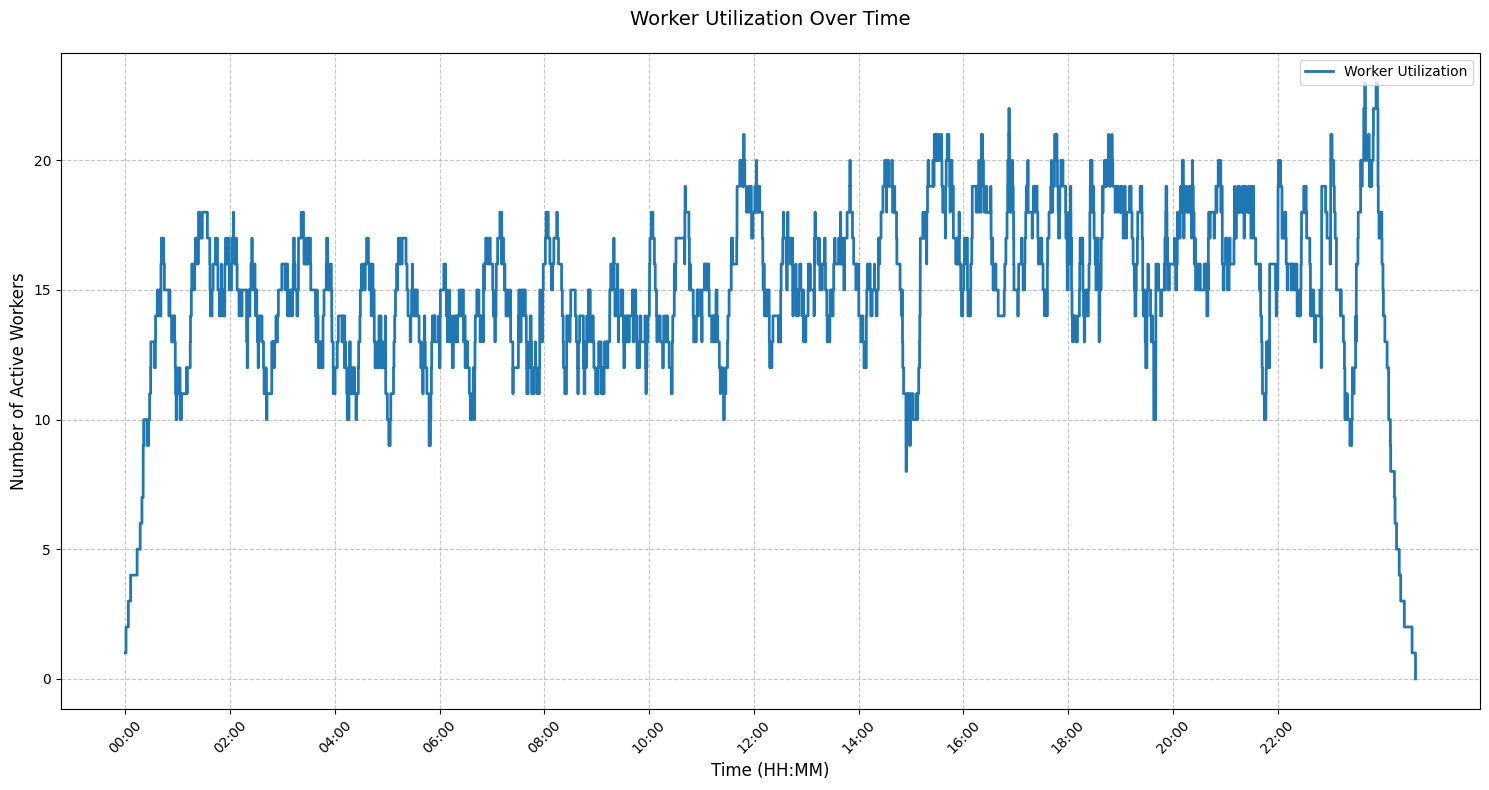

In [61]:
# Create visualization
plt.figure(figsize=(15, 8))
timeline = defaultdict(int)

for job_id, (start_time_str, _) in schedule.items():
    job = jobs_df.loc[jobs_df.id == job_id].iloc[0]
    start_minutes = time_to_seconds(start_time_str) / 60
    duration_minutes = job.duration / 60
    
    timeline[start_minutes] += 1
    timeline[start_minutes + duration_minutes] -= 1

sorted_times = sorted(timeline.keys())
times = []
workers = []
current_workers = 0

for time in sorted_times:
    current_workers += timeline[time]
    times.append(time)
    workers.append(current_workers)

plt.step(times, workers, where='post', label='Worker Utilization', linewidth=2)
plt.title('Worker Utilization Over Time', fontsize=14, pad=20)
plt.xlabel('Time (HH:MM)', fontsize=12)
plt.ylabel('Number of Active Workers', fontsize=12)
xticks = range(0, 24*60, 120)
plt.xticks(xticks, [f"{x//60:02d}:{x%60:02d}" for x in xticks], rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()